In [1]:
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from urllib.parse import urlencode
import requests 
from scipy.stats import shapiro
import scipy.stats
from scipy import stats
from scipy.stats import ttest_ind
from scipy.stats import chi2_contingency

### ЗАДАНИЕ 1. 
Написать функцию, которая будет считать retention игроков (по дням от даты регистрации игрока).

Для начала посмотрим на наши данные. На количество строк и столбцов, типы данных, наличие пропущенных значений, дубликатов.

In [2]:
# данные о времени регистрации
reg_data = pd.read_csv('~/shared/problem1-reg_data.csv', sep = ';')

In [3]:
reg_data.head() # reg_ts - время регистрации; uid - User ID - персональный и постоянный идентификатор пользователя

,reg_ts,uid
0,911382223,1
1,932683089,2
2,947802447,3
3,959523541,4
4,969103313,5


In [4]:
reg_data.shape # строк - 1000000, колонки - 2

(1000000, 2)

In [5]:
reg_data.dtypes # данные представлены в целых числах

reg_ts    int64
uid       int64
dtype: object

In [6]:
reg_data.isna().sum() # пропущенные значения отсутствуют 

reg_ts    0
uid       0
dtype: int64

In [8]:
reg_data.duplicated().sum() #дубликатов нет

0

In [9]:
# данные о времени захода пользователей в игру
auth_data = pd.read_csv('~/shared/problem1-auth_data.csv', sep=';')

In [10]:
auth_data.head()

,auth_ts,uid
0,911382223,1
1,932683089,2
2,932921206,2
3,933393015,2
4,933875379,2


In [11]:
auth_data.shape # строк - 9601013, колонки - 2

(9601013, 2)

In [12]:
auth_data.dtypes # данные представлены в целых числах

auth_ts    int64
uid        int64
dtype: object

In [13]:
auth_data.isna().sum() # пропущенные значения отсутствуют 

auth_ts    0
uid        0
dtype: int64

In [14]:
auth_data.duplicated().sum() # дубликатов нет

0

In [15]:
reg_data.reg_ts = pd.to_datetime(reg_data.reg_ts,unit='s').dt.date # преобразуем дату в UTC формат.

In [16]:
reg_data.reg_ts.head()

0    1998-11-18
1    1999-07-22
2    2000-01-13
3    2000-05-28
4    2000-09-16
Name: reg_ts, dtype: object

In [17]:
auth_data.auth_ts = pd.to_datetime(auth_data.auth_ts,unit='s').dt.date # преобразуем дату в UTC формат.

In [18]:
auth_data.auth_ts.head()

0    1998-11-18
1    1999-07-22
2    1999-07-25
3    1999-07-31
4    1999-08-05
Name: auth_ts, dtype: object

In [19]:
reg_data.reg_ts.agg(['min', 'max']) # смотрим на имеющийся промежуток времени данных. 

min    1998-11-18
max    2020-09-23
Name: reg_ts, dtype: object

In [20]:
df_merge = reg_data.merge(auth_data, how = 'left', on = 'uid') # соединяем таблицы по ID пользователя

In [21]:
df_merge.head()

,reg_ts,uid,auth_ts
0,1998-11-18,1,1998-11-18
1,1999-07-22,2,1999-07-22
2,1999-07-22,2,1999-07-25
3,1999-07-22,2,1999-07-31
4,1999-07-22,2,1999-08-05


In [22]:
df_merge['days'] = df_merge['auth_ts'] - df_merge['reg_ts'] # считаем разницу между днем регистрации и днем захода пользователей в игру

In [23]:
df_merge.dtypes

reg_ts              object
uid                  int64
auth_ts             object
days       timedelta64[ns]
dtype: object

In [24]:
df_merge['days'] = df_merge['days'].dt.days.astype('int16') # Переводим данные в формат целого числа

In [25]:
df_merge.head()

,reg_ts,uid,auth_ts,days
0,1998-11-18,1,1998-11-18,0
1,1999-07-22,2,1999-07-22,0
2,1999-07-22,2,1999-07-25,3
3,1999-07-22,2,1999-07-31,9
4,1999-07-22,2,1999-08-05,14


Создаем функцию, она будет принимать значения: 1) датафрейм, 2) начало даты расчета, 3) конец даты расчета 

In [26]:
def retention_rate (data, start_day, end_day):
    df = df_merge.query('reg_ts >= @start_day and auth_ts <= @end_day')
    
    # retention
    retention = df.pivot_table(index = 'reg_ts', columns = 'days', values = 'uid', aggfunc = 'nunique')
    retention = retention.divide(retention.iloc[:,0],axis='index').iloc[:-1,1:].fillna(0).round(3)
    
    #визуализация
    plt.figure(figsize=(20, 8))
    plt.title('Retention table',fontsize=20, pad=20)
    sns.heatmap(data=retention, annot=True, vmin=0, vmax=0.12, fmt='1.0%', cmap='rocket_r')
    plt.show()
        
    return retention


Проверим работу функции взяв данные за январь 2020 года

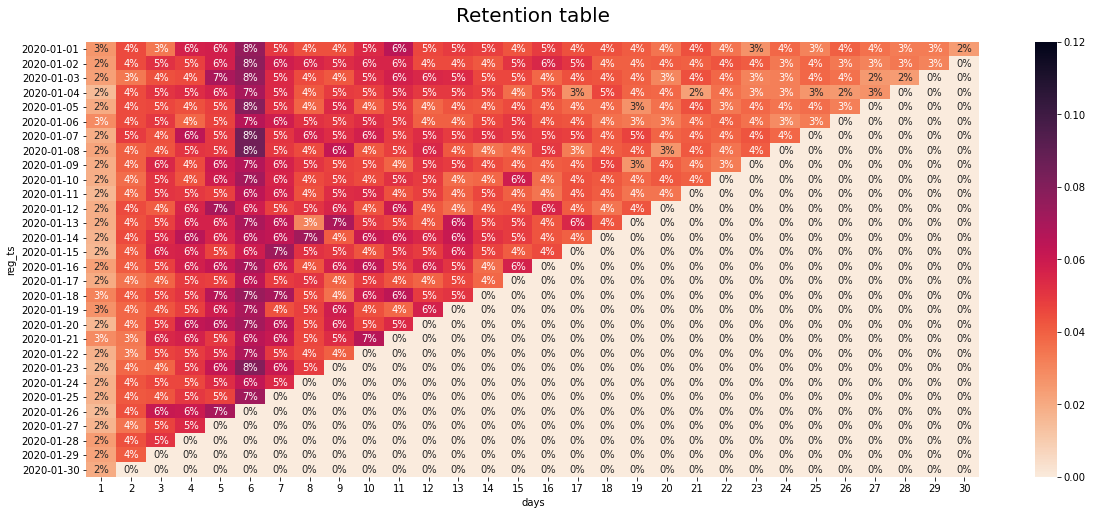

days,1,2,3,4,5,6,7,8,9,10,...,21,22,23,24,25,26,27,28,29,30
reg_ts,,,,,,,,,,,,,,,,,,,,,
2020-01-01,0.026,0.045,0.034,0.057,0.058,0.075,0.050,0.044,0.044,0.054,...,0.044,0.035,0.027,0.038,0.031,0.040,0.036,0.033,0.033,0.024
2020-01-02,0.024,0.045,0.052,0.048,0.058,0.077,0.059,0.056,0.053,0.056,...,0.040,0.043,0.041,0.034,0.038,0.034,0.031,0.034,0.031,0.000
2020-01-03,0.023,0.034,0.044,0.045,0.069,0.075,0.054,0.045,0.042,0.053,...,0.044,0.038,0.031,0.032,0.038,0.036,0.025,0.024,0.000,0.000
2020-01-04,0.015,0.045,0.051,0.053,0.057,0.070,0.054,0.042,0.049,0.048,...,0.023,0.036,0.032,0.032,0.026,0.025,0.027,0.000,0.000,0.000
2020-01-05,0.020,0.045,0.046,0.044,0.048,0.079,0.052,0.039,0.054,0.041,...,0.044,0.034,0.038,0.035,0.037,0.032,0.000,0.000,0.000,0.000
2020-01-06,0.029,0.045,0.050,0.038,0.047,0.066,0.059,0.052,0.050,0.053,...,0.038,0.040,0.036,0.029,0.033,0.000,0.000,0.000,0.000,0.000
2020-01-07,0.019,0.049,0.044,0.064,0.050,0.085,0.051,0.057,0.053,0.058,...,0.041,0.039,0.043,0.038,0.000,0.000,0.000,0.000,0.000,0.000
2020-01-08,0.022,0.040,0.043,0.051,0.050,0.085,0.050,0.045,0.062,0.042,...,0.042,0.035,0.041,0.000,0.000,0.000,0.000,0.000,0.000,0.000
2020-01-09,0.019,0.040,0.055,0.045,0.060,0.067,0.057,0.051,0.047,0.046,...,0.037,0.033,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000


In [27]:
retention_rate (data = df_merge, start_day = datetime.date(2020, 1, 1), end_day = datetime.date(2020, 1, 31))

Проверим работу фунции на данных за февраль 2019 года

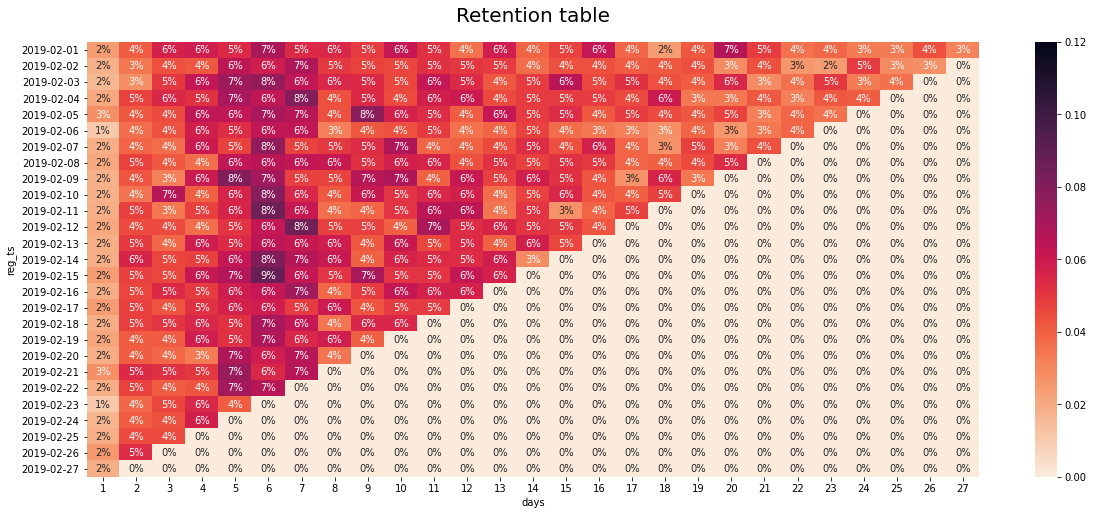

days,1,2,3,4,5,6,7,8,9,10,...,18,19,20,21,22,23,24,25,26,27
reg_ts,,,,,,,,,,,,,,,,,,,,,
2019-02-01,0.024,0.041,0.057,0.059,0.054,0.069,0.054,0.055,0.049,0.062,...,0.024,0.042,0.067,0.049,0.036,0.038,0.033,0.033,0.044,0.031
2019-02-02,0.018,0.034,0.044,0.042,0.064,0.059,0.068,0.050,0.047,0.046,...,0.042,0.044,0.029,0.044,0.026,0.024,0.049,0.029,0.028,0.000
2019-02-03,0.016,0.028,0.050,0.062,0.073,0.075,0.063,0.055,0.054,0.046,...,0.044,0.041,0.055,0.029,0.036,0.050,0.033,0.036,0.000,0.000
2019-02-04,0.021,0.047,0.055,0.052,0.070,0.063,0.080,0.044,0.054,0.045,...,0.060,0.034,0.034,0.042,0.032,0.042,0.041,0.000,0.000,0.000
2019-02-05,0.028,0.042,0.045,0.063,0.063,0.070,0.066,0.044,0.078,0.057,...,0.045,0.042,0.047,0.032,0.039,0.036,0.000,0.000,0.000,0.000
2019-02-06,0.011,0.037,0.044,0.058,0.053,0.063,0.063,0.032,0.042,0.044,...,0.028,0.039,0.026,0.034,0.039,0.000,0.000,0.000,0.000,0.000
2019-02-07,0.019,0.039,0.037,0.060,0.047,0.076,0.047,0.050,0.053,0.068,...,0.027,0.048,0.032,0.044,0.000,0.000,0.000,0.000,0.000,0.000
2019-02-08,0.021,0.047,0.042,0.037,0.063,0.065,0.063,0.061,0.052,0.058,...,0.040,0.045,0.053,0.000,0.000,0.000,0.000,0.000,0.000,0.000
2019-02-09,0.018,0.043,0.032,0.060,0.081,0.071,0.048,0.047,0.066,0.068,...,0.056,0.034,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000


In [28]:
retention_rate (data = df_merge, start_day = datetime.date(2019, 2, 1), end_day = datetime.date(2019, 2, 28))

##### Работоспособность функции проверена

### Задание 2. 
Имеются результаты A/B теста, в котором двум группам пользователей предлагались различные наборы акционных предложений. Известно, что ARPU в тестовой группе выше на 5%, чем в контрольной. При этом в контрольной группе 1928 игроков из 202103 оказались платящими, а в тестовой – 1805 из 202667.
Какой набор предложений можно считать лучшим? Какие метрики стоит проанализировать для принятия правильного решения и как?

In [29]:
# подготовка данных для считывания с внешней ссылки:
base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?'
public_key  = 'https://disk.yandex.ru/d/SOkIsD5A8xlI7Q'
final_url = base_url + urlencode(dict(public_key=public_key))
#считываем данные из файла
response = requests.get(final_url) 
download_url = response.json()['href'] 
download_response = requests.get(download_url) 
#записываем данные в датафрейм
df = pd.read_csv(download_url, sep=';')

In [30]:
df.head()

,user_id,revenue,testgroup
0,1,0,b
1,2,0,a
2,3,0,a
3,4,0,b
4,5,0,b


In [31]:
df.isna().sum() #пропущенных значений нет

user_id      0
revenue      0
testgroup    0
dtype: int64

In [32]:
df.duplicated().sum() #дубликатов нет

0

In [33]:
df.dtypes

user_id       int64
revenue       int64
testgroup    object
dtype: object

In [34]:
df.testgroup.value_counts() # количество наблюдений в обоих группах отличается незначительно

b    202667
a    202103
Name: testgroup, dtype: int64

Посмотрим на доходность по группам.

In [35]:
df.groupby('testgroup')['revenue'].describe()

,count,mean,std,min,25%,50%,75%,max
testgroup,,,,,,,,
a,202103.0,25.413720,920.768137,0.0,0.0,0.0,0.0,37433.0
b,202667.0,26.751287,287.324162,0.0,0.0,0.0,0.0,4000.0


Максимальный чек и стандартное отклонение в группе а значительно выше чем в группе b. 

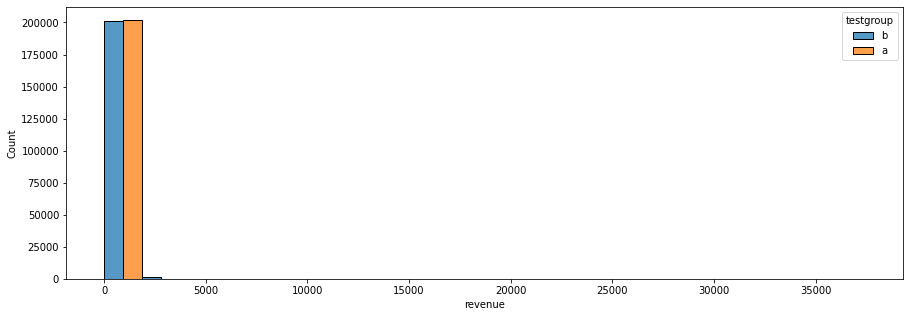

In [36]:
plt.figure(figsize=(15, 5))
ax = sns.histplot(data=df, x='revenue', hue='testgroup', multiple="dodge")

По графику видно что есть много пользователей с нулевыми чеками.
Посмотрим распределение выручки по платящим пользователям

In [37]:
df_a = df.query('testgroup == "a"')
df_b = df.query('testgroup == "b"')
# создали отдельные датафреймы для каждой группы

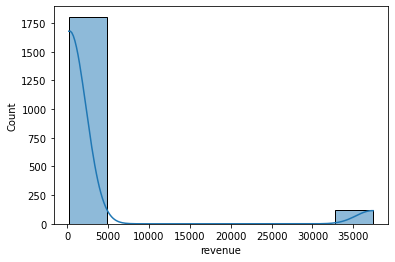

In [38]:
sns.histplot(df_a.query('revenue != 0').revenue, kde = True, bins = 8)
# контрольная группа

По графику видно, что большая часть клиентов совершают покупки на небольшую сумму. Посчитаем какую долю дохода составляют пользователи с чеком больше 30000 (их немного, но они приносят большую часть дохода)

In [39]:
max_spent_clients = df_a.query('revenue > 30000').user_id.nunique()
max_spent_clients

123

123 пользователя с чеком более 30000

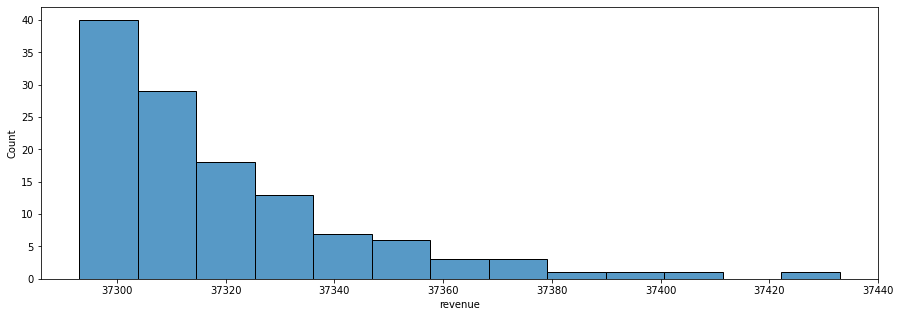

In [40]:
plt.figure(figsize=(15, 5))
sns.histplot(df_a.query('revenue > 30000').revenue)

In [41]:
((df_a.query('revenue > 30000').agg({'revenue':'sum'})/df_a.revenue.sum())*100).round(2)

revenue    89.37
dtype: float64

**Доля дохода** с чеком больше 30 000 составляет **89.37%**. В контрольной группе а большую часть дохода составляют пользователи с высоким чеком (123 пользователя).

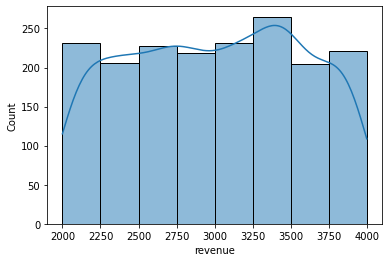

In [42]:
sns.histplot(df_b.query('revenue != 0').revenue, kde = True, bins = 8)
# тестовая группа

В тестовой группе чеки распеределены в диапазоне 2000-4000

Для принятия правильного решения стоит проанализировать следующие **метрики**:

1) **ARPU**  - средний доход на пользователя,
2) **ARPPU** - показывает среднюю прибыль от одного платящего пользователя за определенный период времени,
3) **Конверсия в платящих пользователей**.

In [43]:
df_a = df.query('testgroup == "a"')
df_b = df.query('testgroup == "b"')
# создали отдельные датафреймы для каждой группы

In [44]:
# вычислим ARPU = общая выручка/общее число пользователей
arpu_a = df_a.revenue.sum()/df_a.user_id.count()
arpu_b = df_b.revenue.sum()/df_b.user_id.count()
arpu_a,arpu_b

(25.413719736965806, 26.75128659327863)

In [45]:
# вычислим ARPPU = общая выручка/ кол-во пользователей, совершивших оплату
arppu_a = df_a.revenue.sum() / df_a.query('revenue != 0').user_id.nunique()
arppu_b = df_b.revenue.sum() / df_b.query('revenue != 0').user_id.nunique()
arppu_a, arppu_b

(2663.9984439834025, 3003.6581717451522)

Из имеющихся данных получается, что группа **b** является **тестовой**, группа **a контрольной**.
Несмотря на то, что ARPU в тестовой группе выше нельзя сказать, что этот набор предложений лучше. Необходимо проверить является ли разница статистически значимой.

In [46]:
# вычислим конверсию платящих пользователей (в процентах)
# конверсия платящих пользователей = количество платящих пользователей / общее число пользователей
cr_a = df_a.query('revenue > 0').user_id.count()/df_a.user_id.count()*100
cr_b = df_b.query('revenue > 0').user_id.count()/df_b.user_id.count()*100
cr_a, cr_b

(0.9539690157988748, 0.8906235351586593)

In [47]:
# соберем метрики в табличный вид
metrics = {
    'All_users':[df_a.user_id.count(),df_b.user_id.count(),(df_b.user_id.count()-df_a.user_id.count())/df_a.user_id.count()*100],
    'Paying_users':[df_a.query('revenue != 0').user_id.nunique(),df_b.query('revenue != 0').user_id.nunique(),(df_b.query('revenue != 0').user_id.nunique()-df_a.query('revenue != 0').user_id.nunique())/df_a.query('revenue != 0').user_id.nunique()*100],
    'Revenue':[df_a.revenue.sum(),df_b.revenue.sum(),(df_b.revenue.sum()-df_a.revenue.sum())/df_a.revenue.sum()*100],
    'ARPU':[arpu_a,arpu_b,(arpu_b-arpu_a)/arpu_a*100],
    'ARPPU':[arppu_a,arppu_b,(arppu_b-arppu_a)/arppu_a*100],
    'CR, %':[cr_a,cr_b,(cr_b-cr_a)/cr_a*100],
}
df_metrics = pd.DataFrame(metrics, index=['a', 'b', 'diff, %'])
df_metrics

,All_users,Paying_users,Revenue,ARPU,ARPPU,"CR, %"
a,202103.000000,1928.000000,5.136189e+06,25.413720,2663.998444,0.953969
b,202667.000000,1805.000000,5.421603e+06,26.751287,3003.658172,0.890624
"diff, %",0.279066,-6.379668,5.556922e+00,5.263168,12.749997,-6.640203


**ARPU** в тестовой группе на 5,26% выше, чем в контрольной.

**ARPPU** в тестовой группе на 12,75% выше, чем в контрольной.

**Конверсия** в платящего пользователя в тестовой группе на 6,64% ниже, чем в контрольной.

Общее число пользователей всего на 0,28% ниже в тестовой группе, однако общее число платящих пользователей в тестовой группе ниже на 6,38%, чем в контрольной.

По получившемся данных сложно сказать, какой набор предложений лучше, необходимо провести **статистический анализ** для определения статистической значимости различий между тестовой и контрольной группой.

Проверим распределение на нормальность методом Шапиро-Уилка

In [48]:
shapiro(df_a.revenue.sample(1000, random_state=17)) 

ShapiroResult(statistic=0.06614720821380615, pvalue=0.0)

In [49]:
shapiro(df_b.revenue.sample(1000, random_state=17))

ShapiroResult(statistic=0.06715953350067139, pvalue=0.0)

Оба **распределения ненормальные**, однако сразу отбрасывать t-тест не стоит. У нас имеется большой объем выборки.
Можно провести Бутстрап, он хорошо работает на большом количестве наблюдений, сравнивая выборки, полученные из множества средних значений.
Для конверсии CR будем использовать **хи-квадрат Пирсона**, так как сравниваемые данные качественные и независимые.
Для ARPU и ARPPU можем использовать t-тест или бутстрап. Так как у бутстрап выше риск ошибки второго рода будем использовать **t-тест**.

##### t-test для ARPU

Будем использовать следующие гипотезы:
    
H0 = Значение параметра ARPU статистически равно в обоих выборках.H1 = Значение параметра ARPU статистически не равно в обоих выборках.

С помощью теста Левена проверяем дисперсии на гоменность

In [50]:
scipy.stats.levene(df.query('testgroup == "a"').revenue,
                       df.query('testgroup == "b"').revenue)

LeveneResult(statistic=0.3896289474701388, pvalue=0.5324948591043842)

 p-value > 0.05, дисперсии гомогенны, можем применить критерий t-Стьюдента.

In [51]:
 stat, p = ttest_ind(df[df.testgroup == 'a'].revenue,
                    df[df.testgroup == 'b'].revenue)

print(f'statistic = {stat:.2f}, p-value = {p:.2f}')

statistic = -0.62, p-value = 0.53


p-value > 0.05 нулевая гипотеза принимается. Между средними значениями revenue в контрольной и тестовой группе **нет статистически значимых различий.**

##### t-test для ARPPU

Гипотезы: 
H0 = Значение параметра ARPPU статистически равно в обоих выборках.H1 = Значение параметра ARPPU статистически не равно в обоих выборках.

С помощью теста Левена проверяем дисперсии на гоменность

In [52]:
df_paying = df.query("revenue > 0")

In [53]:
scipy.stats.levene(df_paying[df_paying['testgroup'] == 'a']['revenue'],
                       df_paying[df_paying['testgroup'] == 'b']['revenue'])

LeveneResult(statistic=80.85567421779912, pvalue=3.779689868667878e-19)

p-value < 0.05, дисперсии не гомогенны, применить критерий t-Стьюдента не можем. Используем T-критерий Уэлча, так как там не требуется гомогенность дисперсий.

In [54]:
scipy.stats.ttest_ind(df_paying[df_paying['testgroup'] == 'a']['revenue'],df_paying[df_paying['testgroup'] == 'b']['revenue'], equal_var=False)

Ttest_indResult(statistic=-1.6446302664300838, pvalue=0.10020780398916015)

p-value > 0.05 нулевая гипотеза принимается. Среди платящих пользователей между средними значениями revenue в контрольной и тестовой группе **статистически значимых различий нет.**

##### Конверсия CR

In [55]:
 # создаем таблицу сопряженности
table = pd.crosstab(df.revenue > 0, df.testgroup)

# выполняем тест хи-квадрат
stat, p, dof, expected = chi2_contingency(table)

print(f'statistic = {stat:.2f}, p-value = {p:.2f}')

statistic = 4.37, p-value = 0.04


p-value < 0.05, значения конверсии платящих пользователей между наблюдаемыми и ожидаемыми частотами **статистически значимы.**

### Вывод: 

Конверсия платящих пользователей статистически выше в контрольной группе на 0.06% при статистически не значимых различиях в ARPU и ARPPU. Однако сложно однозначно сказать, что контрольная группа лучше. Пользователи в группах значительно отличаются по размерам платежей, поэтому сложно сранивать неравнозначные группы. А отбросить 123 пользователя с высоким чеком нельзя, иначе анализ будет некорректным. Для принятия правильного решения необходимимо заново провести тест с правильной системой сплитования.

Проведенный анализ не показал, что акционные предложения для тестовой группы лучше, поэтому оставляем текущие акционные предложения.

### Задание 3
В игре Plants & Gardens каждый месяц проводятся тематические события, ограниченные по времени. В них игроки могут получить уникальные предметы для сада и персонажей, дополнительные монеты или бонусы. Для получения награды требуется пройти ряд уровней за определенное время. С помощью каких метрик можно оценить результаты последнего прошедшего события?

Предположим, в другом событии мы усложнили механику событий так, что при каждой неудачной попытке выполнения уровня игрок будет откатываться на несколько уровней назад. Изменится ли набор метрик оценки результата? Если да, то как?

Оценить результаты последнего прошедшего события можно с помощью следующих метрик:
1. **Количество участников и retention**, чтобы узнать стало ли количество игроков больше и привлекло ли их тематическое событие. 
2. **Конверсия пользователей** при проведении тематического события. Смотрим какое количество пользователей из всех заинтересовалось событием. Если СR низкий, возможно событие неинтересно или награды недостаточно мотивируют для участия.
3. **ARPU, ARPPU** - изменился ли доход на платящего пользователя во время тематического события. 
4. **Средняя продлжительность сессии** в тематический день и в обычный. Позволит узнать интересно ли пользователям тематическое событие. Также можно оценить сложность уровней, если продолжительность низкая, возможно тематическое событие неинтересно или задания сложные. 

Если изменить механику событий так, что при каждой неудачной попытке выполнения уровня игрок будет откатываться на несколько уровней назад. Помимо предудыщих метрик, стоит также рассмотреть:

**Сhurn rate**, позволит узнать отток пользователей и на каком уровне они уходят. Если отток будет высокий - возможно механика игры слишком сложная и её нужно облегчить или увеличить награду для большей мотивации в прохождении уровней. 